# Multiclass Classification Model using CNN - Case Study

## Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **<font color='blue'>1. Data Understanding & Pre-processing</font>**

In [ ]:
##Importing all the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#Connecting with Google Drive for the files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change dir to your project folder
root_path = 'gdrive/My Drive/CNN_Assignment_Data/Skin cancer ISIC The International Skin Imaging Collaboration'  

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
#Checking the Image Counts
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 1.1 Load Images using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
#Let us define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

### 1.1.1 Create Train/Validation Dataset

-  We will split 80% of the images for training, and 20% for validation.
-  We will also be using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
-  Further we will be resizing the images to the size img_height*img_width, while writting the dataset

In [ ]:
#Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12827 files belonging to 9 classes.
Using 10262 files for training.


In [ ]:
#Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12827 files belonging to 9 classes.
Using 2565 files for validation.


In [ ]:
# Now we will list out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 1.2 Visualize the data

-  We will create a code to visualize one instance of all the nine classes present in the dataset.

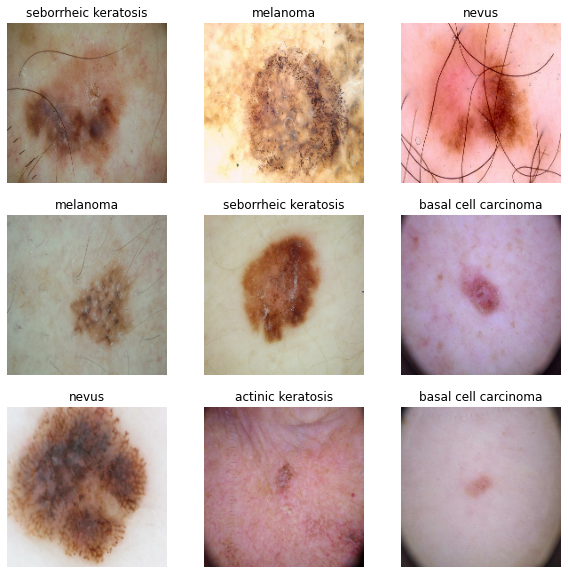

In [ ]:
plt.figure(figsize=(10, 10))
for img,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Observations:**

-  The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

**Note** -

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **<font color='blue'>2. Creating Model</font>**

-  We will create a CNN model, which can accurately detect 9 classes present in the dataset.
-  We will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
-  The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize     values to be in the `[0, 1]` range.

## 2.1 Model 1

In [ ]:
### Code for model creation
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  
])

## 2.1.1 Compile the model

In [ ]:
# We have selected an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## 2.1.2 Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
321/321 [==============================] - 3709s 2s/step - loss: 1.7514 - accuracy: 0.3319 - val_loss: 1.4274 - val_accuracy: 0.4795
Epoch 2/20
321/321 [==============================] - 13s 42ms/step - loss: 1.1756 - accuracy: 0.5637 - val_loss: 1.0908 - val_accuracy: 0.5981
Epoch 3/20
321/321 [==============================] - 13s 41ms/step - loss: 0.8495 - accuracy: 0.6943 - val_loss: 0.7981 - val_accuracy: 0.7177
Epoch 4/20
321/321 [==============================] - 13s 41ms/step - loss: 0.5975 - accuracy: 0.7925 - val_loss: 0.6667 - val_accuracy: 0.7598
Epoch 5/20
321/321 [==============================] - 13s 41ms/step - loss: 0.4565 - accuracy: 0.8413 - val_loss: 0.5293 - val_accuracy: 0.8234
Epoch 6/20
321/321 [==============================] - 13s 41ms/step - loss: 0.3394 - accuracy: 0.8820 - val_loss: 0.4891 - val_accuracy: 0.8347
Epoch 7/20
321/321 [==============================] - 13s 41ms/step - loss: 0.2956 - accuracy: 0.9005 - val_loss: 0.4240 - val_accuracy:

## 2.1.3 Visualizing training results

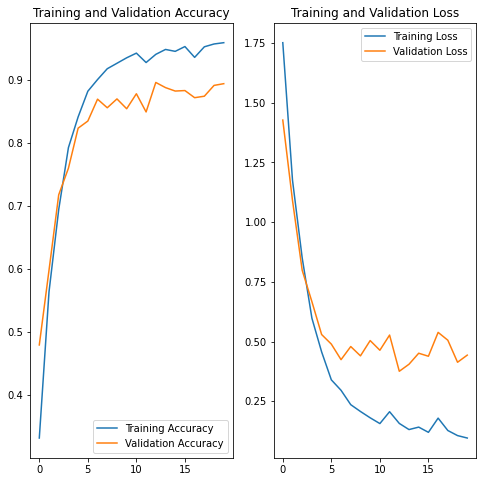

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations from Model 1:**

-  As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

-  **Overfitting**: In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy is only around 55% in the training process. This difference is a clear indicator of overfitting

In [ ]:
# We will now choose an appropriate data augmentation strategy to address the Overfitting.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

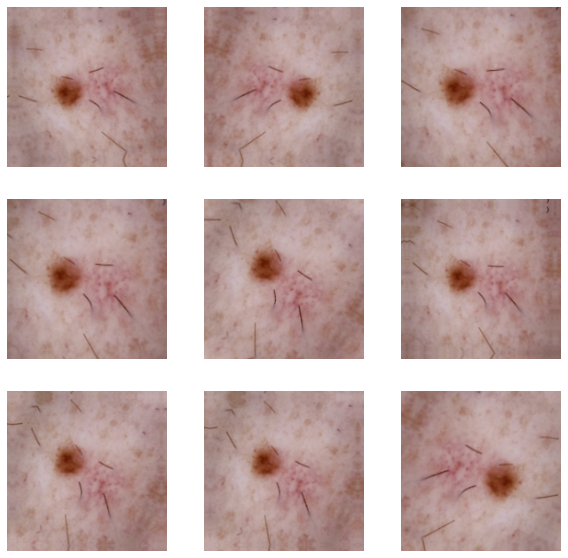

In [ ]:
# Now we will visualize how the augmentation strategy has worked for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 2.2 Model 2

In [ ]:
#Code
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 2.2.1 Compiling the model

In [ ]:
#Code
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### 2.2.2 Training the model

In [ ]:
# Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
321/321 [==============================] - 16s 47ms/step - loss: 1.7084 - accuracy: 0.3510 - val_loss: 1.3867 - val_accuracy: 0.4710
Epoch 2/20
321/321 [==============================] - 15s 47ms/step - loss: 1.3582 - accuracy: 0.4866 - val_loss: 1.2561 - val_accuracy: 0.5142
Epoch 3/20
321/321 [==============================] - 15s 47ms/step - loss: 1.2522 - accuracy: 0.5254 - val_loss: 1.2001 - val_accuracy: 0.5513
Epoch 4/20
321/321 [==============================] - 15s 47ms/step - loss: 1.1813 - accuracy: 0.5544 - val_loss: 1.0963 - val_accuracy: 0.5747
Epoch 5/20
321/321 [==============================] - 15s 47ms/step - loss: 1.0775 - accuracy: 0.5939 - val_loss: 0.9869 - val_accuracy: 0.6390
Epoch 6/20
321/321 [==============================] - 15s 47ms/step - loss: 1.0284 - accuracy: 0.6133 - val_loss: 0.9938 - val_accuracy: 0.6347
Epoch 7/20
321/321 [==============================] - 15s 47ms/step - loss: 0.9214 - accuracy: 0.6557 - val_loss: 0.8506 - val_accuracy:

### 2.2.3 Visualizing the results

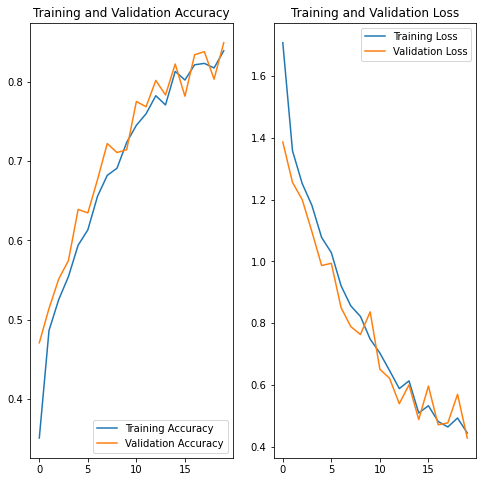

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations from Model 2:**

-  After data augmentation overfitting has been reduced significantly.

###  Find the distribution of classes in the training dataset.

 **Context:** 
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

## 2.3 Counting each class

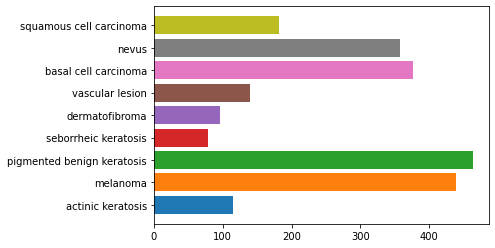

In [ ]:
import os
path = '/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

**Observations from Model 2:**
#### - Which class has the least number of samples? - **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? **pigmented benign keratosis**

### 2.3.1 Rectify the class imbalance

 **Context:**
We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = '/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
print(path_to_training_dataset)

/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


### **To use Augmentor, the following general procedure is followed:**

-  Instantiate a Pipeline object pointing to a directory containing your initial image data set.
-  Define a number of operations to perform on this data set using your Pipeline object.
-  Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
## We are adding 500 samples per class to make sure that none of the classes are sparse.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5EAFC0790>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5E70D94D0>: 100%|██████████| 500/500 [00:22<00:00, 22.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA5E655F190>: 100%|██████████| 500/500 [00:22<00:00, 21.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7FA63010BA90>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FA5E6645D10>: 100%|██████████| 500/500 [01:39<00:00,  5.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5E70D9590>: 100%|██████████| 500/500 [00:22<00:00, 21.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA5E657C710>: 100%|██████████| 500/500 [00:49<00:00, 10.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA5E661F990>: 100%|██████████| 500/500 [00:23<00:00, 21.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5E6645AD0>: 100%|██████████| 500/500 [00:23<00:00, 21.01 Samples/s]


In [ ]:
data_dir_train = pathlib.Path(path_to_training_dataset)
print(data_dir_train)

/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


**Observations**

-  #### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
-  #### Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

15088


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_50e0f6e8-81c2-4649-a72b-4f8ca9bef3ef.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_af8ec602-688b-4db2-96bd-27dd8371de29.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_817e61f5-33c1-4d00-8386-6a8569f7acac.jpg',
 '/content/gdrive/MyDrive/CNN_Assignment_Data/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_07104019-172e-47ff-8632-565825414eeb.jpg',
 '/content/gdrive/MyDrive/CNN_Assign

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

basal cell carcinoma          2376
actinic keratosis             2114
dermatofibroma                2095
melanoma                      2026
pigmented benign keratosis    1962
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
seborrheic keratosis          1577
Name: Label, dtype: int64

**Observations**

-  So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 2.4 Model 3 - Train the model on the data created using Augmentor

In [ ]:
#Define the parameters
batch_size = 32
img_height = 180
img_width = 180

### 2.4.1 Create Train/Validation Dataset

In [ ]:
#Training Set
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 17327 files belonging to 9 classes.
Using 13862 files for training.


In [ ]:
#Validation Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17327 files belonging to 9 classes.
Using 3465 files for validation.


### 2.4.2 Creating the model including normalization

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03398587 0.9294118


### 2.4.3 Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2.4.4 Train the model

In [ ]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
434/434 [==============================] - 94s 212ms/step - loss: 0.4476 - accuracy: 0.8370 - val_loss: 0.3690 - val_accuracy: 0.8719
Epoch 2/30
434/434 [==============================] - 86s 196ms/step - loss: 0.4197 - accuracy: 0.8458 - val_loss: 0.3000 - val_accuracy: 0.8973
Epoch 3/30
434/434 [==============================] - 85s 194ms/step - loss: 0.4043 - accuracy: 0.8533 - val_loss: 0.3009 - val_accuracy: 0.8889
Epoch 4/30
434/434 [==============================] - 85s 194ms/step - loss: 0.3844 - accuracy: 0.8576 - val_loss: 0.4080 - val_accuracy: 0.8545
Epoch 5/30
434/434 [==============================] - 86s 195ms/step - loss: 0.3805 - accuracy: 0.8622 - val_loss: 0.3367 - val_accuracy: 0.8921
Epoch 6/30
434/434 [==============================] - 86s 196ms/step - loss: 0.3592 - accuracy: 0.8660 - val_loss: 0.2727 - val_accuracy: 0.9001
Epoch 7/30
434/434 [==============================] - 86s 195ms/step - loss: 0.3553 - accuracy: 0.8742 - val_loss: 0.3970 - val_ac

### 2.4.5 Visualize the model results

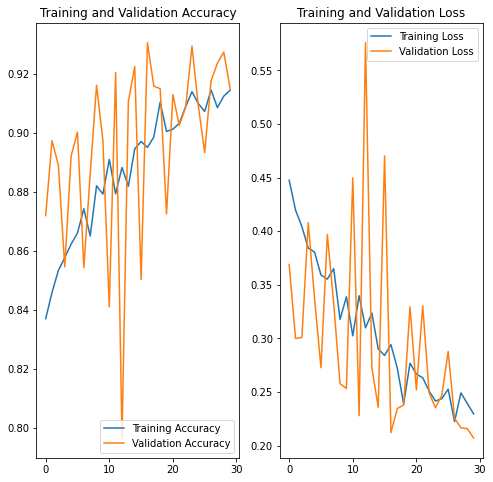

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Observations**

- ### The above results in graph and training data indicate that the accuracy has improved and that there is no overfitting of the model.
- ### Yes , class rebalancing helped to increase the accuracy significantly.